In [31]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, io

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

(a)

In [32]:
dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


In [33]:
#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.Lambda(lambda x: x / 255) 
#])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

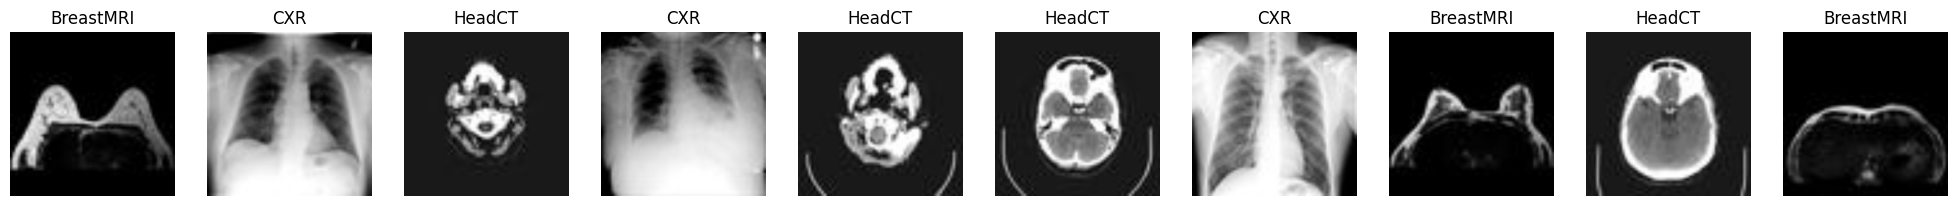

In [34]:
dataset = datasets.ImageFolder(root='resized', transform=transform)

def show_images(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(25, 3))
    for ax in axes:
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(dataset.classes[label]) 
        ax.axis('off')
    plt.show()

show_images(dataset)

In [35]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

(b)

In [36]:
class MedCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(MedCNN, self).__init__()

        # conv1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # conv2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # FC layers
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
    
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = MedCNN(num_classes=6)

print(model)

MedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


(c)

In [37]:
# validate GPU  availability

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

In [18]:
# hyperparameter setup
batch_size = 16
learning_rate=0.001
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

model = MedCNN(num_classes=6)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

torch.cuda.is_available()
device = torch.device("cuda")
model.to(device)

train_losses, val_losses = [], []

In [20]:
for e in range(epochs):
    model.train()
    epochloss = 0.0

    for img, labels in train_loader:
        optim.zero_grad()
        img, labels = img.to(device), labels.to(device)
        outputs = model(img)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()
        epochloss += loss.item()
    train_losses.append(epochloss / len(train_loader))

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for img, labels in val_loader:
            img, labels = img.to(device), labels.to(device)
            outputs = model(img)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_losses.append(val_running_loss / len(val_loader))

    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 1/10, Train Loss: 0.04272023801815454, Validation Loss: 0.15035531914627415
Epoch 2/10, Train Loss: 0.025985611111006533, Validation Loss: 0.013783478902770693
Epoch 3/10, Train Loss: 0.010332152020467398, Validation Loss: 0.008334367854675003
Epoch 4/10, Train Loss: 0.007725172802305747, Validation Loss: 0.005015295681590611
Epoch 5/10, Train Loss: 0.006568177218671975, Validation Loss: 0.002099445305674706
Epoch 6/10, Train Loss: 0.005960758387147107, Validation Loss: 0.0015302747129320464
Epoch 7/10, Train Loss: 0.011329372660278942, Validation Loss: 0.003902918767943201
Epoch 8/10, Train Loss: 0.005750242938513504, Validation Loss: 0.0033963600766599984
Epoch 9/10, Train Loss: 0.001277088956778452, Validation Loss: 0.0030078122201131286
Epoch 10/10, Train Loss: 0.013662671831743496, Validation Loss: 0.008450068614740748


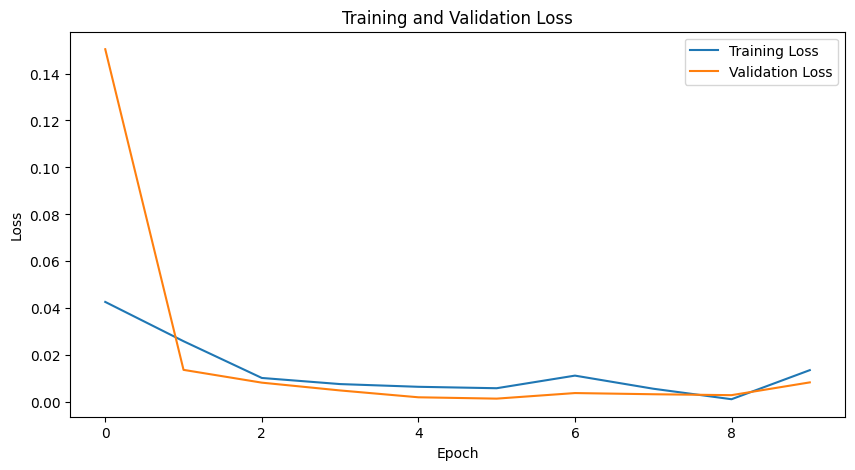

In [21]:
# plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(d)

In [10]:
# hyperparameter setup 1
batch_size = 25
learning_rate=0.001

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [11]:
model = MedCNN(num_classes=6)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
torch.cuda.is_available()
device = torch.device("cuda")
model.to(device)

MedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

In [16]:
epochs = 10
train_losses, val_losses = [], []

for e in range(epochs):
    model.train()
    epochloss = 0.0

    for img, labels in train_loader:
        optim.zero_grad()
        img, labels = img.to(device), labels.to(device)
        outputs = model(img)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()
        epochloss += loss.item()
    train_losses.append(epochloss / len(train_loader))

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for img, labels in val_loader:
            img, labels = img.to(device), labels.to(device)
            outputs = model(img)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_losses.append(val_running_loss / len(val_loader))

    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 1/10, Train Loss: 0.05575737302439734, Validation Loss: 0.011062266585413762
Epoch 2/10, Train Loss: 0.012159268989568716, Validation Loss: 0.007300801198881158
Epoch 3/10, Train Loss: 0.00734636451082842, Validation Loss: 0.005137434583488186
Epoch 4/10, Train Loss: 0.011466479823125686, Validation Loss: 0.00383808168416022
Epoch 5/10, Train Loss: 0.010547827528333132, Validation Loss: 0.005436939395410578
Epoch 6/10, Train Loss: 0.002665869457213192, Validation Loss: 0.0020625882155674057
Epoch 7/10, Train Loss: 0.011033205922146273, Validation Loss: 0.003989103332456832
Epoch 8/10, Train Loss: 0.0016127279832324718, Validation Loss: 0.0033407645660321447
Epoch 9/10, Train Loss: 0.0013018359985900398, Validation Loss: 0.008745309173396986
Epoch 10/10, Train Loss: 0.015223100717970941, Validation Loss: 0.007418521394988305


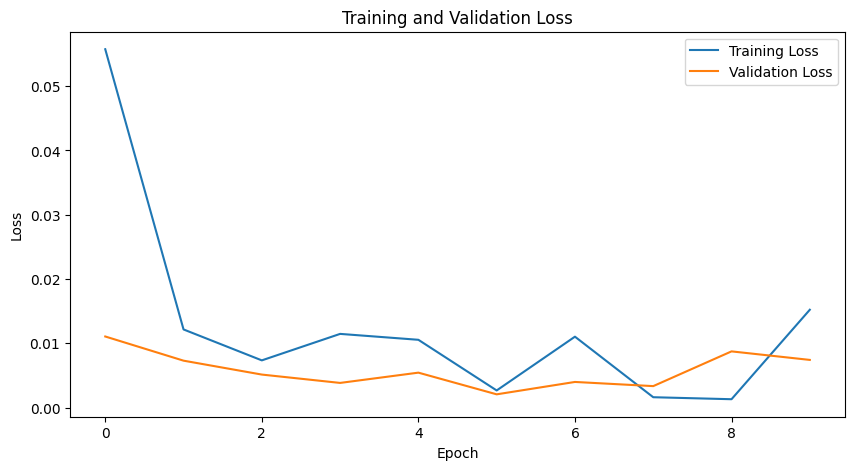

In [17]:
# plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
# hyperparameter setup 2
batch_size = 114
learning_rate=0.0005
epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

model = MedCNN(num_classes=6)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
torch.cuda.is_available()

True

In [22]:
device = torch.device("cuda")
model.to(device)

train_losses, val_losses = [], []

for e in range(epochs):
    model.train()
    epochloss = 0.0

    for img, labels in train_loader:
        optim.zero_grad()
        img, labels = img.to(device), labels.to(device)
        outputs = model(img)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()
        epochloss += loss.item()
    train_losses.append(epochloss / len(train_loader))

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for img, labels in val_loader:
            img, labels = img.to(device), labels.to(device)
            outputs = model(img)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_losses.append(val_running_loss / len(val_loader))

    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 1/10, Train Loss: 0.04797797272621316, Validation Loss: 0.013117470390660366
Epoch 2/10, Train Loss: 0.014906751052560079, Validation Loss: 0.002560268114988363
Epoch 3/10, Train Loss: 0.001927905194509785, Validation Loss: 0.0018888862058212487
Epoch 4/10, Train Loss: 0.002777607576970353, Validation Loss: 0.002269277206454927
Epoch 5/10, Train Loss: 0.0012007944520369743, Validation Loss: 0.004396071346945973
Epoch 6/10, Train Loss: 0.0015796063349960063, Validation Loss: 0.004479747904973954
Epoch 7/10, Train Loss: 0.010792094216316706, Validation Loss: 0.004961069274661265
Epoch 8/10, Train Loss: 0.001606411224751297, Validation Loss: 0.001306100411800169
Epoch 9/10, Train Loss: 0.0003569833691566857, Validation Loss: 0.0018183306090620022
Epoch 10/10, Train Loss: 0.00012516601322777683, Validation Loss: 0.001156584175168208


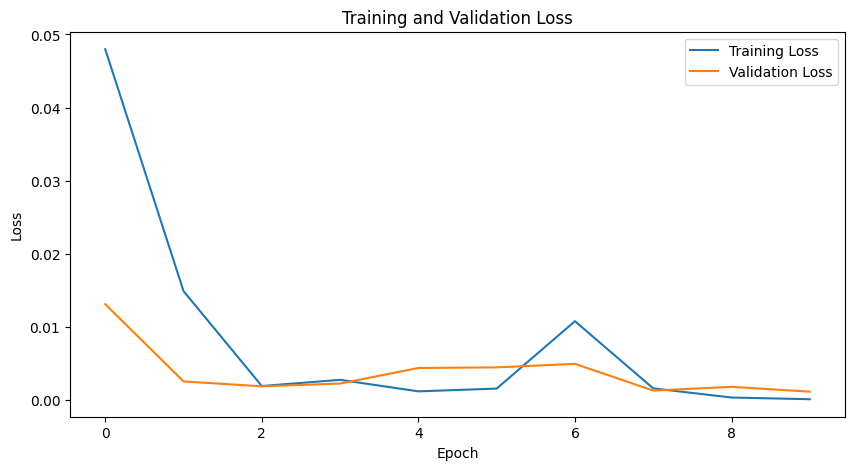

In [23]:
# plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(e)

In [40]:
model.eval()
true_labels = []
predictions = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())


In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(true_labels, predictions, target_names=['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']))

# Overall accuracy
accuracy = accuracy_score(true_labels, predictions)
print("Overall accuracy:", accuracy)

              precision    recall  f1-score   support

   AbdomenCT       0.00      0.00      0.00      1015
   BreastMRI       0.00      0.00      0.00       923
     ChestCT       0.17      1.00      0.30      1030
         CXR       0.00      0.00      0.00       993
        Hand       0.00      0.00      0.00       974
      HeadCT       0.00      0.00      0.00       962

    accuracy                           0.17      5897
   macro avg       0.03      0.17      0.05      5897
weighted avg       0.03      0.17      0.05      5897

Overall accuracy: 0.17466508394098695


c:\Users\skyya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\skyya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\skyya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

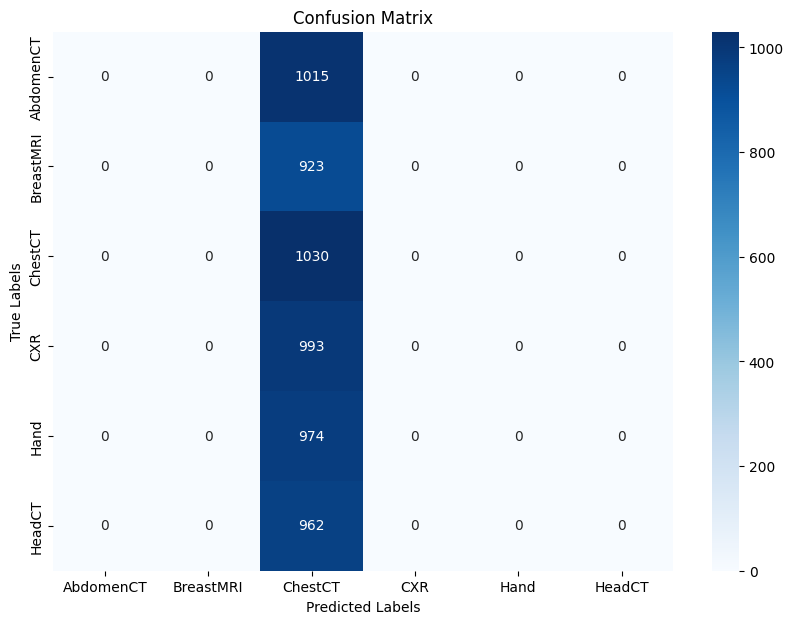

In [42]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT'], yticklabels=['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

While the model has learned to identify "ChestCT" images to some extent, it fails almost entirely with other classes ("AbdomenCT," "BreastMRI," "CXR," "Hand," "HeadCT"), as indicated by the zero values in precision, recall, and f1-score.